In [6]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

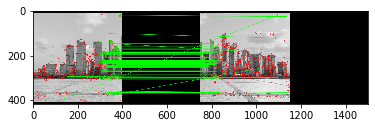

In [7]:
top, bot, left, right = 10, 10, 0, 350  # 边缘扩充
img1 = cv.imread('left.jpg')
img2 = cv.imread('right.jpg')
srcImg = cv.copyMakeBorder(img1, top, bot, left, right, cv.BORDER_CONSTANT, value=(0, 0, 0))
testImg = cv.copyMakeBorder(img2, top, bot, left, right, cv.BORDER_CONSTANT, value=(0, 0, 0))
img1gray = cv.cvtColor(srcImg, cv.COLOR_BGR2GRAY)
img2gray = cv.cvtColor(testImg, cv.COLOR_BGR2GRAY)
sift = cv.xfeatures2d.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1gray, None)
kp2, des2 = sift.detectAndCompute(img2gray, None)
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0, 0] for i in range(len(matches))]

good = []
pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i, (m, n) in enumerate(matches):
    if m.distance < 0.7 * n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        matchesMask[i] = [1, 0]

draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask,
                   flags=0)
img3 = cv.drawMatchesKnn(img1gray, kp1, img2gray, kp2, matches, None, **draw_params)
plt.imshow(img3, )
plt.show()

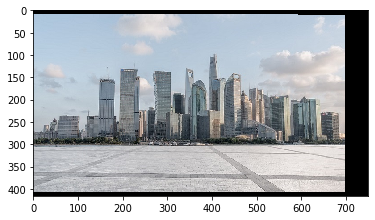

In [8]:
rows, cols = srcImg.shape[:2]
MIN_MATCH_COUNT = 10
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    warpImg = cv.warpPerspective(testImg, np.array(M), (testImg.shape[1], testImg.shape[0]),
                                 flags=cv.WARP_INVERSE_MAP)

    for col in range(0, cols):
        if srcImg[:, col].any() and warpImg[:, col].any():
            left = col
            break
    for col in range(cols - 1, 0, -1):
        if srcImg[:, col].any() and warpImg[:, col].any():
            right = col
            break

    res = np.zeros([rows, cols, 3], np.uint8)
    for row in range(0, rows):
        for col in range(0, cols):
            if not srcImg[row, col].any():
                res[row, col] = warpImg[row, col]
            elif not warpImg[row, col].any():
                res[row, col] = srcImg[row, col]
            else:
                srcImgLen = float(abs(col - left))
                testImgLen = float(abs(col - right))
                alpha = srcImgLen / (srcImgLen + testImgLen)
                res[row, col] = np.clip(srcImg[row, col] * (1 - alpha) + warpImg[row, col] * alpha, 0, 255)

    # opencv is bgr, matplotlib is rgb
    res = cv.cvtColor(res, cv.COLOR_BGR2RGB)
    # show the result
    plt.figure()
    plt.imshow(res)
    plt.show()
else:
    matchesMask = None